In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
if None:
    print("True")

In [50]:
import itertools
import json
from pathlib import Path
from datetime import timedelta, datetime
from scipy.sparse import csr_matrix, vstack



from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from wikipedia_cleanup.data_processing import get_data
from wikipedia_cleanup.data_filter import KeepAttributesDataFilter, generate_default_filters

In [4]:
mp_drive_dir = Path("/media/hpi_share/")#Path("//FS23/projekte$/MP2021/MPWS2021/MPWS2021FN1")
mp_plot_dir = mp_drive_dir / "plots"
input_path = Path("../../../data/custom-format-default-filtered/")

In [234]:
n_files=20
n_jobs=0
filters = generate_default_filters()
keep_filter = KeepAttributesDataFilter(['page_id', 'infobox_key', 'page_title', 'property_name', 'previous_value' ,'current_value', 'value_valid_from', 'value_valid_to'])
filters.append(keep_filter)
df = get_data(input_path,n_files=n_files, n_jobs=n_jobs, filters=filters)

20it [00:40,  2.00s/it]


In [235]:
data = df

In [236]:
data = data[data['previous_value'] != '']
data = data[data['current_value'] != '']

In [237]:
data = data[~data['previous_value'].isnull()]
data = data[~data['current_value'].isnull()]
data = data.copy()

# Working with sparse arrays

In [238]:
def create_time_series(a, duration):
    series = np.zeros(duration)
    uniques, counts = np.unique(a, return_counts=True)
    series[uniques] = counts
    return csr_matrix(series)

def create_bool_time_series(a, duration):
    series = np.zeros(duration, dtype=bool)
    uniques, counts = np.unique(a, return_counts=True)
    series[uniques] = 1
    return series

In [239]:
%%time
bins = pd.date_range(data['value_valid_from'].min().date(), data['value_valid_from'].max().date()+timedelta(1))
total_days = len(bins)
bins = pd.cut(data['value_valid_from'], bins, labels=False)
data['bin_idx'] = bins

num_required_changes = 5
groups = data.groupby(['infobox_key', 'property_name'])
min_support_groups = data[groups['bin_idx'].transform('count') > num_required_changes].groupby(['infobox_key', 'page_id', 'property_name'])
min_support_groups = min_support_groups['bin_idx'].apply(create_time_series, duration=total_days)

CPU times: user 19.3 s, sys: 8.21 ms, total: 19.3 s
Wall time: 19.3 s


In [240]:
print(f"Number of properties: {len(groups)}")
group_index = min_support_groups.index
#x = groups.loc["100593997-0"].values
x = vstack(min_support_groups.to_numpy())
print(f"Len min support groups : {x.shape[0]}")
#x = csr_matrix(x)

Number of properties: 176943
Len min support groups : 57800


## Working just with lists

In [148]:
groups = data.groupby(['infobox_key', 'property_name'])
num_required_changes = 5
min_support_groups = data[groups['value_valid_from'].transform('count') > num_required_changes]#.groupby(['infobox_key', 'property_name'])
min_support_groups['value_valid_from'] = min_support_groups['value_valid_from'].dt.date
min_support_groups = min_support_groups.groupby(['infobox_key', 'property_name'])['value_valid_from'].apply(list)

/home/niklaskoehnecke/project/wikipedia_cleanup/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [149]:
x = min_support_groups.to_numpy()

In [ ]:
%load_ext Cython

In [ ]:
func(x[i], x[j])

## Nearest Neighbors
Probably more suited than clustering methods

In [241]:
def percentage_manhatten(arr1, arr2):
    arr1 = arr1.toarray()
    arr2 = arr2.toarray()
    return np.sum(np.absolute(arr1 - arr2)) / max(arr1.sum(), arr2.sum())

In [242]:
def percentage_manhatten_improved(arr1, arr2):
    arr1 = arr1.toarray()
    arr2 = arr2.toarray()
    mask = np.nonzero(arr1)
    return np.sum(np.absolute(arr1[mask] - arr2[mask])) / arr1.sum()

In [243]:
def percentage_manhatten_exact_time_lag(arr1, arr2):
    arr1 = arr1.toarray()
    arr2 = arr2.toarray()
    max_changes = max(arr1.sum(), arr2.sum())
    time_lagged_distances = [np.sum(np.absolute(arr1 - np.pad(arr2,((0,0),(i,0)), mode='constant')[:, :-i])) for i in range(1,8)]
    time_lagged_distances.append(np.sum(np.absolute(arr1 - arr2)))
    return np.min(time_lagged_distances) / max_changes

In [244]:
temp = min_support_groups.reset_index()
temp = temp.groupby(['page_id'])[['property_name', 'bin_idx', 'infobox_key']].agg(list)

In [245]:
from tqdm.auto import tqdm

In [246]:
%%time

max_dist = 0

same_infoboxes = []
for key, row in tqdm(temp.iterrows(), total=len(temp)):
    if len(row[1]) > 1:
        input_data = vstack(row[1])
        neighbor_indices = []
        #for i in range(input_data.shape[0]):
        #    current_neighbors = []
        #    for j in range(input_data.shape[0]):
        #        if i != j:
        #            current_dist = percentage_manhatten(input_data[i], input_data[j])
        #            if current_dist <= max_dist:
        #                current_neighbors.append(j)
        #    neighbor_indices.append(current_neighbors)
        neigh = NearestNeighbors(radius=max_dist, metric=percentage_manhatten_improved)#
        neigh.fit(input_data)
        dist, neighbor_indices = neigh.radius_neighbors()
        for i, neighbors in enumerate(neighbor_indices):
            infobox = row[2][i]
            if len(neighbors) > 0:
                infobox_keys = np.array(row[2])[neighbors]
                same_infobox = infobox_keys == infobox
                same_infoboxes.append(same_infobox)


  0%|          | 0/16937 [00:00<?, ?it/s]

CPU times: user 1min 8s, sys: 154 ms, total: 1min 8s
Wall time: 1min 8s


In [247]:
num_matches = []
percent_same_matched = []
max_num_matches = 100
for i in range(1, max_num_matches):
    num_matches.append(np.sum(np.fromiter( (len(a) for a in same_infoboxes), dtype=int) == i))
    percent_same_matched.append(np.mean([np.sum(entry) / i for entry in same_infoboxes if len(entry) == i]))
percent_same_infobox = np.multiply(num_matches, percent_same_matched)

/home/niklaskoehnecke/project/wikipedia_cleanup/.venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/niklaskoehnecke/project/wikipedia_cleanup/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [232]:
num_matches[:10]

[320, 101, 40, 20, 6, 0, 0, 0, 0, 0]

In [204]:
num_matches[:10]

[124, 27, 20, 5, 0, 0, 0, 0, 0, 0]

In [186]:
baseline

[279, 83, 31, 15, 10, 1, 0, 4, 0, 0]

In [179]:
baseline = num_matches[:10]

Text(0.1, 0, 'Color represents the % of matches that are not from the same infobox')

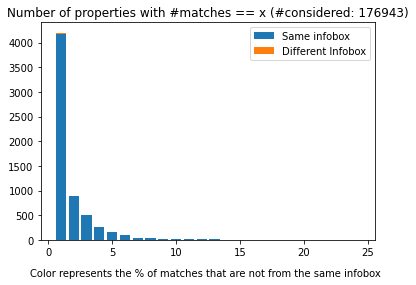

In [248]:
plt.bar(range(1, max_num_matches), percent_same_infobox, label='Same infobox')
plt.bar(range(1, max_num_matches), num_matches-percent_same_infobox, bottom = percent_same_infobox, label='Different Infobox')
plt.legend(loc='upper right')
plt.title(f"Number of properties with #matches == x (#considered: {len(groups)})")
plt.figtext(0.1, 0, "Color represents the % of matches that are not from the same infobox")

# Old nearest neighbor code

In [24]:
max_dist = 2
#max_dist = 0.2
neigh = NearestNeighbors(radius=max_dist, p=1)
#neigh = NearestNeighbors(radius=max_dist, metric=percentage_eucledian)
neigh.fit(x)

NearestNeighbors(p=1, radius=2)

In [25]:
%%time
dist, ind = neigh.radius_neighbors()

CPU times: user 15min 42s, sys: 19.8 s, total: 16min 1s
Wall time: 2min 45s


In [26]:
a = group_index.values
same_infobox = []
for i, indices in enumerate(ind):
    infobox = group_index[i][0]
    if len(indices) > 0:
        matching_pages = np.array([key[0] for key in group_index[indices]])
        same_infobox.append(infobox == matching_pages)
n_total = len(ind)
n_matched = len(same_infobox)

In [27]:
print(f"number of pages considered: {data['page_id'].nunique()}")

number of pages considered: 55108


/home/niklaskoehnecke/project/wikipedia_cleanup/.venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/niklaskoehnecke/project/wikipedia_cleanup/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.1, 0, 'Color represents the % of matches that are not from the same infobox')

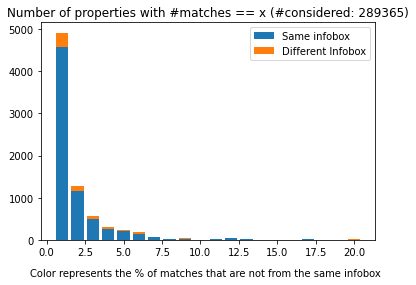

In [28]:
num_matches = []
percent_same_matched = []
max_num_matches = 100
for i in range(1, max_num_matches):
    num_matches.append(np.sum(np.fromiter( (len(a) for a in same_infobox), dtype=int) == i))
    percent_same_matched.append(np.mean([np.sum(entry) / i for entry in same_infobox if len(entry) == i]))
percent_same_infobox = np.multiply(num_matches, percent_same_matched)
plt.bar(range(1, max_num_matches), percent_same_infobox, label='Same infobox')
plt.bar(range(1, max_num_matches), num_matches-percent_same_infobox, bottom = percent_same_infobox, label='Different Infobox')
plt.legend(loc='upper right')
plt.title(f"Number of properties with #matches == x (#considered: {len(groups)})")
plt.figtext(0.1, 0, "Color represents the % of matches that are not from the same infobox")

In [29]:
#0.963084495488105
# 95 93 87 87 95
# 93 91 84 93 87
# 94 91 80 90 88
percent_same_matched

[0.9316517493897477,
 0.9107704402515723,
 0.8635307781649244,
 0.8401360544217688,
 0.8596638655462184,
 0.8333333333333334,
 0.7087912087912088,
 0.6206896551724138,
 0.8136200716845877,
 0.6285714285714284,
 0.5418181818181818,
 0.8842592592592593,
 0.8942307692307692,
 0.26530612244897955,
 0.7523809523809525,
 0.125,
 1.0,
 nan,
 1.0,
 0.1,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

Look at some of the examples
 - Many examples have just creation / deletion
 - When filtering these out, some examples are:
     - batting averages (247568784-0), box2..., Statistics in general
     - Temperature reading for cities (infoboxes that are basically plots) - https://de.wikipedia.org/wiki/Ottawa
     - Uniforms for soccer games and stuff https://en.wikipedia.org/wiki/FC_Bayern_Munich_(women)
     - Perfect synchronous data https://en.wikipedia.org/wiki/Delta_County_Airport
     - Career listings and other list elements - https://en.wikipedia.org/wiki/Akaki_Khubutia
     - Stuff that is updated real time, once (Elections https://en.wikipedia.org/wiki/2019_European_Parliament_election_in_the_United_Kingdom)
     - railway stations , passenger numbers (https://en.wikipedia.org/wiki/Windsor_station_(Vermont))
     - Vandalism

In [ ]:
a = group_index[ind[np.array([len(g) for g in ind]) > 2][70]]
print(a)
a = a[6]
data[(data['name'] == a[1]) & (data['key'] == a[0])]

In [ ]:
data[data['key'] == '131458332-1']

In [ ]:
data[data['key'] == '131458332-2']

In [ ]:
data[(data['name'] == 'ability') & (data['key'] == '131458332-2')]

In [ ]:
ind[np.array([len(g) for g in ind]) > 20]

In [ ]:
group_index[ind[np.array([len(g) for g in ind]) > 20][123]]
data[(data['key'] == '110474295-0') & (data['name'] == 'area_rank')]

## KShape, apparently good fast clustering
Seems to be ill-suited for the job

In [ ]:
plt.figure(figsize=(100,2))
for k, row in groups.loc["100593997-0"].items():
    plt.plot(row)

In [ ]:
from tslearn.clustering import KShape
n_clusters = 4
classifier = KShape(n_clusters)
classifier.fit(x)
predictions = classifier.predict(x)

In [ ]:
for i in range(n_clusters):
    selected_data = x[predictions==i]
    plt.figure(figsize=(100,2))
    for j in range(len(selected_data)):
        plt.plot(selected_data[j])
    plt.show()

## DBScan

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
from dtaidistance import dtw

In [ ]:
print(dtw.distance.__doc__)

In [ ]:
def change_distance(a, b):
    return dtw.distance(a, b, window=14, use_pruning=True, use_c=True)

In [ ]:
x.shape

In [ ]:
%%time
clustering = DBSCAN(eps=1, min_samples=2, n_jobs=6, metric=change_distance).fit(x)

In [ ]:
clusters = np.unique(clustering.labels_)
n_clusters = len(clusters)
if -1 in clusters:
    n_clusters -=1

In [ ]:
for i in range(n_clusters):
    selected_data = x[clustering.labels_==i]
    plt.figure(figsize=(100,2))
    for j in range(len(selected_data)):
        plt.plot(selected_data[j])
    plt.show()